# Neural Networks - A Practical Introduction
by _Minho Menezes_  

---

## Multilayer Perceptron for Computer Vision

In this third and last notebook, we will get an experience about how to work with image data and use our Neural models for Computer Vision tasks. This will give you a brief introduction in one of the fields where Neural Networks are most widely used, and will show you that this Multilayer Perceptron class that we built really works. 

* [1. Image Data Extraction](#1.-Image-Data-Extraction)  
* [2. Loading the MNIST Dataset](#2.-Loading-the-MNIST-Dataset)  
* [3. Training the Network](#3.-Training-the-Network)  
* [4. Testing the Network](#4.-Testing-the-Network)  

---


### Libraries

In [1]:
## LIBRARIES ##
import numpy as np                         # Library for Numerical and Matricial Operations
import matplotlib.pyplot as plt            # Library for Generating Visualizations
import pandas as pd                        # Library for Handling Datasets
from tools import Tools as tl              # Library for some Utilitary Tools
from glob import glob                      # Library for File Searching

# Function for loading the MNIST dataset into a Numpy Matrix
import pickle

def loadMNIST():
    with open("../data/mnist/mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"].T, mnist["test_images"].T, mnist["training_labels"].T, mnist["test_labels"].T

### The Neural Networks Class

In [38]:
## CLASS: Multilayer Perceptron ##
class MultilayerPerceptron:
    
    # CLASS CONSTRUCTOR
    def __init__(self, n_neurons=[2, 5, 1]):
        if(len(n_neurons) < 2):
            raise ValueError("The network must have at least two layers! (The input and the output layers)")
        
        # Network Architecture
        self.hidden_layers = len(n_neurons)-2
        self.n_neurons = n_neurons
        self.W = []
        
        # Adjusting the Network architecture
        for i in range(1, len(n_neurons)):
            self.W.append( np.random.randn(self.n_neurons[i-1]+1 , self.n_neurons[i]) )
        
    # ACTIVATION FUNCTION
    def activate(self,Z):
        return 1 / (1 + np.exp(-Z))
    
    # FORWARD PROPAGATION
    def forward(self, X):
        # Activation List
        A = []
        
        # Input Layer Activation
        A.append( np.vstack([np.ones([1, X.shape[1]]), X]) )
        
        # Hidden Layer Activation
        for i in range(0, self.hidden_layers):
            Z = np.matmul(self.W[i].T, A[-1])
            Z = self.activate(Z)
            
            A.append( np.vstack([np.ones([1, Z.shape[1]]), Z]) )
        
        # Output Layer Activation
        Z = np.matmul(self.W[-1].T, A[-1])
        Z = self.activate(Z)

        A.append(Z)
        
        return A
    
    # CLASSIFICATION PREDICTION
    def predict(self, X):
        A = self.forward(X)
        
        if(self.n_neurons[-1] > 1):
            return A[-1].argmax(axis=0)
        else:
            return (A[-1] > 0.5).astype(int)
    
    # LOSS FUNCTION
    def loss(self, y, y_hat):
        m = y.shape[1]
        return -(1/m) * np.sum(y * np.log(y_hat) + (1-y) * np.log(1 - y_hat))
    
    # ACCURACY FUNCTION
    def accuracy(self, y, y_hat):
        m = y.shape[1]
        if(y.shape[0] > 1):
            y = y.argmax(axis=0)
        
        return (1/m) * np.sum(y == y_hat) * 100
    
    # BACKPROPAGATION
    def backpropagate(self, A, y):
        # Calculates the error in the Output Layer (difference between the real and the predicted)
        E = []
        E.append( A[-1] - y )

        # Backpropagates the error to all the Hidden Layers
        for i in range(self.hidden_layers, 0, -1):
            E.append( np.matmul(self.W[i], E[-1]) * A[i] * (1-A[i]) )
            E[-1] = E[-1][1:,:]

        # Returns the list of Error Matrices
        return E[::-1]
    
    # GRADIENT DESCENT TRAINING
    def train(self, X_train, y_train, alpha=1e-3, maxIt=50000, tol=1e-5, verbose=True):
        # Returns the total number of samples in the training
        m = X_train.shape[1]

        # Defines the Error History and other auxiliary variables
        errorHist = []

        # Gradient Descent Loop
        for it in range(0, maxIt):
            # 1. Calculates all the activations and prediction (Forward Propagation) and 
            #    the errors (Backpropagation), using the current weights self.Wˆ(i)
            A = self.forward(X_train)
            E = self.backpropagate(A, y_train)
            P = self.predict(X_train)

            # 2. Calculates the Evaluation Metrics
            actualLoss = self.loss(y_train, A[-1])
            actualAcc = self.accuracy(y_train, P)
            errorHist.append(actualLoss)

            # 3. Updates the Neural Networks weights
            for i in range(0, self.hidden_layers+1):
                self.W[i] = self.W[i] - (alpha/m) * np.matmul(A[i], E[i].T)

            # 4. Prints the training results
            if(verbose): 
                print("# Iteration {0:5} -> Loss: {1:} \t| Accuracy: {2:.3f}".format(it+1, actualLoss, actualAcc))

            # 5. Check for convergence and prints the final result for the training.
            if(it > 1 and abs(errorHist[-1] - errorHist[-2]) <= tol):
                print("\n!!! Convergence reached !!!")
                print("# Iteration", it, "#")
                print("Cross-Entropy Loss:      {}".format(actualLoss))
                print("Accuracy (Training Set): {0:.3f}%".format(actualAcc))
                print("Weights\nS -> H:\n", self.W[0], "\nH -> O:\n", self.W[1])
                print("\n")
                break;

        # End of the Training
        return errorHist
        
## ---------------------------- ##

---

### 1. Image Data Extraction

When working with Computer Vision, the first thing you need, of course, is to be able to open image data and format it to some shape that your Neural Network can understand. This is a step in this field known as **Feature Extraction**. Consider the case of the following image:

<img src="../data/mnist/mnist1.png" alt="binary multilayer perceptron" width="100px"/>

There are, mainly, two ways that we can feed this image to a Neural Network:

1. We can extract, in advance, some informations that descripts the image (mean of colors, borders positions, center of mass, etc.) and build a vector comprising these descriptions. This vector is then used as a Input Layer to the Neural Network.

2. The entire image (28x28 pixels, in this case) is arranged into a vector shape. This vector (that will have dimension 784x1) is then used as a Input Layer to the Neural Network.

Of course, in the first case it is possible that we form a set of features that is much smaller than 784 (in the second case), hence performing faster. However, this process can be time-consuming and maybe some information will still be missing. The second case requires more memory and processing power, but usually yields a better performance. We will stick to the second approach, now, because this are actually one of the reasons that Neural Networks are popular right now.

**To build your own dataset from image data, first use the function _plt.imread()_ to capture the matrices of a image and the function _plt.imshow()_ to visualize it:**

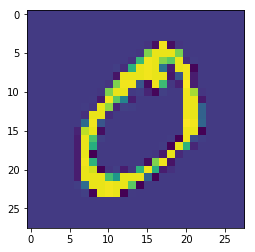

In [3]:
# Open an image and returns the pixel matrices
X = plt.imread("../data/mnist/mnist1.png")

# Selects only the pixel intensity for one of the RGBA channels
X = X[:,:,0]

# Exhibits the image loaded in such matrix
plt.figure()
plt.imshow(X)
plt.show()

To flatten the entire image to an array of specific dimensions, we use the method _.reshape()_ from the Numpy matrices. 

In [4]:
# Flatten the image to a column vector
X = X.reshape(-1, 1)

print("Dimensions of X:", X.shape)

Dimensions of X: (784, 1)


This is only one image. In order to built an entire dataset, we need to iteratively load and reshape all the images that we have in our database:

In [5]:
# Returns the name of all PNG files in the MNIST folder
filenames = glob("../data/mnist/*.png")

# Creates the dataset by horizontally stacking the individual images
X = np.zeros([28*28, len(filenames)])
for i,f in enumerate(filenames):
    img = plt.imread(f)
    img = img[:,:,0]
    X[:,i] = img.reshape(1,-1)
    
# Prints part of the dataset
print("Dataset:\n", X)
print("\nDimensions:", X.shape)

Dataset:
 [[0.26666668 0.26666668 0.26666668 ... 0.26666668 0.26666668 0.26666668]
 [0.26666668 0.26666668 0.26666668 ... 0.26666668 0.26666668 0.26666668]
 [0.26666668 0.26666668 0.26666668 ... 0.26666668 0.26666668 0.26666668]
 ...
 [0.26666668 0.26666668 0.26666668 ... 0.26666668 0.26666668 0.26666668]
 [0.26666668 0.26666668 0.26666668 ... 0.26666668 0.26666668 0.26666668]
 [0.26666668 0.26666668 0.26666668 ... 0.26666668 0.26666668 0.26666668]]

Dimensions: (784, 9)


Finally, we need to indicate the real class of each image. This work is usually done manually to label each image by actually looking at it.

In this case, we first visualize each example of our dataset:

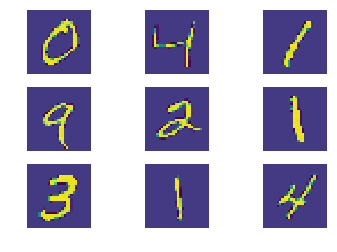

In [8]:
# Exhibits the images in the dataset
plt.figure()
for i in range(0,3):
    for j in range(0,3):
        plt.subplot(3,3,j + 3*i +1)
        plt.imshow(X[:,j + 3*i].reshape(28,28))
        plt.axis('off')

plt.show()

Then, we manually create the labels vector $Y$:

In [9]:
# Defines the label classes:
y = np.array(["0", "4", "1", "9", "2", "1", "3", "1", "4"])

### 2. Loading the MNIST Dataset

You could be worried if a dataset with only 9 samples is enough to train a Neural Network. You are right.

The number of samples needed to train a Neural Network varies from the problem and the architecture of the network. The intention is to get as much data as possible, but they also must have great variance to expose the network to several possible cases. In the Computer Vision case, however, the number of input is too great, and the Networks tends to be proportionally as big. In this case we need very big datasets.

The **[MNIST dataset](http://yann.lecun.com/exdb/mnist/)** is a very popular dataset of 70,000 images of handwritten digits that are used as benchmark data for several machine learning models. Actually the images that you used before are samples of this dataset.

**We will then, work with this data:**

In [39]:
# Loads the entire MNIST dataset
X_train, X_test, y_train, y_test = loadMNIST()

# Creating the One-Hot Encoding labels
y_train_ohe = np.zeros([10, y_train.shape[0]])
for i in range(0, y_train.shape[0]):
    y_train_ohe[y_train[i], i] = 1

y_test_ohe = np.zeros([10, y_test.shape[0]])
for i in range(0, y_test.shape[0]):
    y_test_ohe[y_test[i], i] = 1

We can also visualize samples from this dataset by using the _.reshape()_ and the _plt.imshow()_ functions:

Labels:

	7	6	2	5	0	
	4	0	3	2	5	
	9	2	4	5	9	

Images:


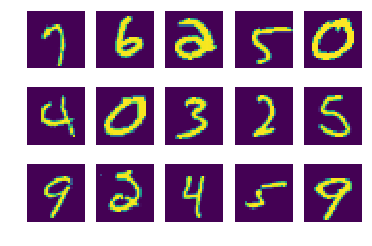

In [14]:
# Exhibits the images in the dataset
print("Labels:")

plt.figure()
for i in range(0,3):
    print(end="\n\t")
    for j in range(0,5):
        plt.subplot(3,5,j + 5*i +1)
        
        # Selects a random example from the dataset
        idx = np.random.randint(0, 60000)
        print(y_train[idx], end="\t")
        plt.imshow(X_train[:,idx].reshape(28,28))
        
        plt.axis('off')


print("\n\nImages:")
plt.show()

### 3. Training the Network

Now, we have a entire dataset and we already built our Neural Network class. We are ready to train a network to work with this data.

A quick reminder: the Network will have _748_ Input Labels, a arbitrary number _N_ of Random Neurons and _10_ Output Neurons. This means that we will have _748xN + N*10_ weights to update! Furthermore, we have 60000 training examples. So, you can imagine that this training will be a lot slower (and harder!) than those of the previous notebooks.

But fear not! The network can still learn something if we choose a significantly higher number of Hidden Neurons; it will work, but will take a lot of time. Use a small number of Hidden Neurons in order to visualize the training, and (if you computer is fast enough) you can use more neurons later.

**The training itself should be equal to the previous cases, just remember to match the dimensions:**

In [40]:
# Creates the Neural Network with 2 Input Neurons, 10 Hidden Neurons and 4 Output Neuron
# (The weights are randomnly initiated)
brain = MultilayerPerceptron(n_neurons=[28*28, 10, 10])

# Run the Gradient Descent and returns the Error History for the training.
errorHist = brain.train(X_train, y_train_ohe, alpha=0.1)

# Iteration     1 -> Loss: 9.26188408371542 	| Accuracy: 13.947
# Iteration     2 -> Loss: 8.44249905565116 	| Accuracy: 13.535
# Iteration     3 -> Loss: 7.744467943322247 	| Accuracy: 13.362
# Iteration     4 -> Loss: 7.172812125934414 	| Accuracy: 12.563
# Iteration     5 -> Loss: 6.683869920854961 	| Accuracy: 12.613
# Iteration     6 -> Loss: 6.274769190549216 	| Accuracy: 12.615
# Iteration     7 -> Loss: 5.933065060184531 	| Accuracy: 12.555
# Iteration     8 -> Loss: 5.6470850013137435 	| Accuracy: 12.657
# Iteration     9 -> Loss: 5.408483130371432 	| Accuracy: 12.675
# Iteration    10 -> Loss: 5.203568716650019 	| Accuracy: 12.640
# Iteration    11 -> Loss: 5.029578821559296 	| Accuracy: 12.052
# Iteration    12 -> Loss: 4.88539063895556 	| Accuracy: 12.047
# Iteration    13 -> Loss: 4.759755322327465 	| Accuracy: 12.110
# Iteration    14 -> Loss: 4.647163250742028 	| Accuracy: 12.152
# Iteration    15 -> Loss: 4.548439144660528 	| Accuracy: 12.172
# Iteration    16 -> Loss: 

# Iteration   127 -> Loss: 3.184833951423863 	| Accuracy: 19.105
# Iteration   128 -> Loss: 3.182081952748148 	| Accuracy: 19.165
# Iteration   129 -> Loss: 3.1797174424098102 	| Accuracy: 20.493
# Iteration   130 -> Loss: 3.1773259027334246 	| Accuracy: 20.528
# Iteration   131 -> Loss: 3.17495259982761 	| Accuracy: 20.558
# Iteration   132 -> Loss: 3.1725537412809395 	| Accuracy: 20.580
# Iteration   133 -> Loss: 3.1699152389577474 	| Accuracy: 20.585
# Iteration   134 -> Loss: 3.1672665575324017 	| Accuracy: 20.583
# Iteration   135 -> Loss: 3.1651369323708125 	| Accuracy: 20.623
# Iteration   136 -> Loss: 3.1629860215124594 	| Accuracy: 20.617
# Iteration   137 -> Loss: 3.1608976061453617 	| Accuracy: 20.660
# Iteration   138 -> Loss: 3.1587855239537648 	| Accuracy: 20.645
# Iteration   139 -> Loss: 3.156582702190251 	| Accuracy: 20.680
# Iteration   140 -> Loss: 3.154761025783033 	| Accuracy: 20.695
# Iteration   141 -> Loss: 3.152485035631606 	| Accuracy: 20.717
# Iteration   142

# Iteration   253 -> Loss: 2.9709073035875466 	| Accuracy: 30.255
# Iteration   254 -> Loss: 2.969437738602198 	| Accuracy: 30.282
# Iteration   255 -> Loss: 2.9679872991280027 	| Accuracy: 30.288
# Iteration   256 -> Loss: 2.966793029952509 	| Accuracy: 30.277
# Iteration   257 -> Loss: 2.9657342005804406 	| Accuracy: 30.278
# Iteration   258 -> Loss: 2.964407794578188 	| Accuracy: 30.303
# Iteration   259 -> Loss: 2.962904327211876 	| Accuracy: 30.337
# Iteration   260 -> Loss: 2.9615778131248702 	| Accuracy: 30.368
# Iteration   261 -> Loss: 2.960278147534624 	| Accuracy: 30.460
# Iteration   262 -> Loss: 2.9588199629358396 	| Accuracy: 31.040
# Iteration   263 -> Loss: 2.957466346578415 	| Accuracy: 31.037
# Iteration   264 -> Loss: 2.956194528016811 	| Accuracy: 31.082
# Iteration   265 -> Loss: 2.954700815134397 	| Accuracy: 31.088
# Iteration   266 -> Loss: 2.95368744095322 	| Accuracy: 31.097
# Iteration   267 -> Loss: 2.952625801974519 	| Accuracy: 31.087
# Iteration   268 -> 

# Iteration   379 -> Loss: 2.830006520542479 	| Accuracy: 34.490
# Iteration   380 -> Loss: 2.829182363102595 	| Accuracy: 34.512
# Iteration   381 -> Loss: 2.8278930038990286 	| Accuracy: 34.553
# Iteration   382 -> Loss: 2.826702166252524 	| Accuracy: 34.558
# Iteration   383 -> Loss: 2.825713914916387 	| Accuracy: 34.607
# Iteration   384 -> Loss: 2.824545137867665 	| Accuracy: 34.613
# Iteration   385 -> Loss: 2.823325229177649 	| Accuracy: 34.643
# Iteration   386 -> Loss: 2.8222900462719034 	| Accuracy: 34.673
# Iteration   387 -> Loss: 2.8212931218101227 	| Accuracy: 34.697
# Iteration   388 -> Loss: 2.820385872786067 	| Accuracy: 34.713
# Iteration   389 -> Loss: 2.8197221178927396 	| Accuracy: 34.712
# Iteration   390 -> Loss: 2.8190947282298673 	| Accuracy: 34.717
# Iteration   391 -> Loss: 2.817839263263855 	| Accuracy: 34.745
# Iteration   392 -> Loss: 2.8168654282310572 	| Accuracy: 34.763
# Iteration   393 -> Loss: 2.815937774311823 	| Accuracy: 34.803
# Iteration   394 -

# Iteration   504 -> Loss: 2.7217216461039895 	| Accuracy: 37.813
# Iteration   505 -> Loss: 2.720896045875295 	| Accuracy: 37.828
# Iteration   506 -> Loss: 2.7200390451048038 	| Accuracy: 37.858
# Iteration   507 -> Loss: 2.7195923946111145 	| Accuracy: 37.848
# Iteration   508 -> Loss: 2.718971392553575 	| Accuracy: 37.885
# Iteration   509 -> Loss: 2.7179683543056483 	| Accuracy: 37.878
# Iteration   510 -> Loss: 2.7172234102183266 	| Accuracy: 37.885
# Iteration   511 -> Loss: 2.7166113691695646 	| Accuracy: 37.927
# Iteration   512 -> Loss: 2.715741029042677 	| Accuracy: 37.945
# Iteration   513 -> Loss: 2.71497116925865 	| Accuracy: 37.902
# Iteration   514 -> Loss: 2.7138297868045975 	| Accuracy: 37.938
# Iteration   515 -> Loss: 2.713247639261488 	| Accuracy: 37.962
# Iteration   516 -> Loss: 2.7122901710564844 	| Accuracy: 37.962
# Iteration   517 -> Loss: 2.711419519167547 	| Accuracy: 38.017
# Iteration   518 -> Loss: 2.7107453415341833 	| Accuracy: 38.010
# Iteration   519

# Iteration   629 -> Loss: 2.628566583831533 	| Accuracy: 39.920
# Iteration   630 -> Loss: 2.6274801630430615 	| Accuracy: 39.952
# Iteration   631 -> Loss: 2.6266288942175793 	| Accuracy: 39.977
# Iteration   632 -> Loss: 2.625985126156779 	| Accuracy: 39.982
# Iteration   633 -> Loss: 2.625688381870895 	| Accuracy: 39.978
# Iteration   634 -> Loss: 2.625034124012005 	| Accuracy: 39.972
# Iteration   635 -> Loss: 2.6243869673994196 	| Accuracy: 39.985
# Iteration   636 -> Loss: 2.6241837982202063 	| Accuracy: 39.980
# Iteration   637 -> Loss: 2.6232968745511567 	| Accuracy: 40.007
# Iteration   638 -> Loss: 2.622722701386512 	| Accuracy: 40.027
# Iteration   639 -> Loss: 2.6220428682128842 	| Accuracy: 40.022
# Iteration   640 -> Loss: 2.6215048214214254 	| Accuracy: 40.042
# Iteration   641 -> Loss: 2.6206877197019165 	| Accuracy: 40.045
# Iteration   642 -> Loss: 2.6201028618934843 	| Accuracy: 40.070
# Iteration   643 -> Loss: 2.619410532740993 	| Accuracy: 40.075
# Iteration   64

# Iteration   754 -> Loss: 2.543163837146969 	| Accuracy: 43.343
# Iteration   755 -> Loss: 2.542924196097196 	| Accuracy: 43.343
# Iteration   756 -> Loss: 2.5423989395637014 	| Accuracy: 43.342
# Iteration   757 -> Loss: 2.542065938061623 	| Accuracy: 43.370
# Iteration   758 -> Loss: 2.5410726196709024 	| Accuracy: 43.382
# Iteration   759 -> Loss: 2.540667986556846 	| Accuracy: 43.408
# Iteration   760 -> Loss: 2.5397568051593487 	| Accuracy: 43.418
# Iteration   761 -> Loss: 2.539381116334543 	| Accuracy: 43.442
# Iteration   762 -> Loss: 2.539179249947746 	| Accuracy: 43.420
# Iteration   763 -> Loss: 2.5388072359315514 	| Accuracy: 43.445
# Iteration   764 -> Loss: 2.5382993266758453 	| Accuracy: 43.422
# Iteration   765 -> Loss: 2.5372643785550193 	| Accuracy: 43.502
# Iteration   766 -> Loss: 2.5366985008120864 	| Accuracy: 43.537
# Iteration   767 -> Loss: 2.535977254597311 	| Accuracy: 43.552
# Iteration   768 -> Loss: 2.5356670880944634 	| Accuracy: 43.565
# Iteration   769

# Iteration   880 -> Loss: 2.479527506193371 	| Accuracy: 45.538
# Iteration   881 -> Loss: 2.4791212117768193 	| Accuracy: 45.543
# Iteration   882 -> Loss: 2.4784682906757136 	| Accuracy: 45.548
# Iteration   883 -> Loss: 2.477878448528554 	| Accuracy: 45.552
# Iteration   884 -> Loss: 2.476974214886534 	| Accuracy: 45.577
# Iteration   885 -> Loss: 2.4765273233619665 	| Accuracy: 45.588
# Iteration   886 -> Loss: 2.4761956202513753 	| Accuracy: 45.600
# Iteration   887 -> Loss: 2.475676020851685 	| Accuracy: 45.582
# Iteration   888 -> Loss: 2.4753695341009414 	| Accuracy: 45.620
# Iteration   889 -> Loss: 2.474782396146242 	| Accuracy: 45.627
# Iteration   890 -> Loss: 2.473973678432129 	| Accuracy: 45.673
# Iteration   891 -> Loss: 2.4734400555389997 	| Accuracy: 45.675
# Iteration   892 -> Loss: 2.4729972179653585 	| Accuracy: 45.693
# Iteration   893 -> Loss: 2.472939776693261 	| Accuracy: 45.697
# Iteration   894 -> Loss: 2.4719603892214925 	| Accuracy: 45.703
# Iteration   895

# Iteration  1006 -> Loss: 2.4175736235528094 	| Accuracy: 46.798
# Iteration  1007 -> Loss: 2.4170756452050126 	| Accuracy: 46.803
# Iteration  1008 -> Loss: 2.4164940734149956 	| Accuracy: 46.815
# Iteration  1009 -> Loss: 2.416156663923709 	| Accuracy: 46.825
# Iteration  1010 -> Loss: 2.4155800041957813 	| Accuracy: 46.847
# Iteration  1011 -> Loss: 2.4149648203250376 	| Accuracy: 46.857
# Iteration  1012 -> Loss: 2.4147456464689316 	| Accuracy: 46.882
# Iteration  1013 -> Loss: 2.414173273870408 	| Accuracy: 46.872
# Iteration  1014 -> Loss: 2.413868882977265 	| Accuracy: 46.890
# Iteration  1015 -> Loss: 2.4133980143826563 	| Accuracy: 46.880
# Iteration  1016 -> Loss: 2.4128843380166147 	| Accuracy: 46.907
# Iteration  1017 -> Loss: 2.4123238362781128 	| Accuracy: 46.933
# Iteration  1018 -> Loss: 2.412165867508362 	| Accuracy: 46.908
# Iteration  1019 -> Loss: 2.4114145385417602 	| Accuracy: 46.958
# Iteration  1020 -> Loss: 2.411022614100221 	| Accuracy: 46.945
# Iteration  10

# Iteration  1132 -> Loss: 2.366367646551208 	| Accuracy: 48.453
# Iteration  1133 -> Loss: 2.3658040845422046 	| Accuracy: 48.482
# Iteration  1134 -> Loss: 2.365503331786766 	| Accuracy: 48.453
# Iteration  1135 -> Loss: 2.3646703236939217 	| Accuracy: 48.475
# Iteration  1136 -> Loss: 2.36393643536235 	| Accuracy: 48.522
# Iteration  1137 -> Loss: 2.363620746727259 	| Accuracy: 48.518
# Iteration  1138 -> Loss: 2.3632925112605756 	| Accuracy: 48.535
# Iteration  1139 -> Loss: 2.362944809169129 	| Accuracy: 48.568
# Iteration  1140 -> Loss: 2.3626591387241134 	| Accuracy: 48.533
# Iteration  1141 -> Loss: 2.3615492565322054 	| Accuracy: 48.600
# Iteration  1142 -> Loss: 2.3613309311815542 	| Accuracy: 48.585
# Iteration  1143 -> Loss: 2.361215833816067 	| Accuracy: 48.595
# Iteration  1144 -> Loss: 2.3604965349227736 	| Accuracy: 48.622
# Iteration  1145 -> Loss: 2.3598896614723093 	| Accuracy: 48.650
# Iteration  1146 -> Loss: 2.359595914694571 	| Accuracy: 48.652
# Iteration  1147 

### 4. Testing the Network

Once our network is properly trained, we can use it to classify the digits. In this case, since we are dealing with high-dimensional data, we will not be able to generate visualizations for the entire space as we did before, since it would be infeasible to try to plot the digits into two-dimensional spaces.

We can, however, try to sample some digits from the dataset and classify them, in order to see the network in practice. Remember, also, that we can rely in the _Evaluation Metrics_ to understand the quality of the models we trained.

**In the cell below, try to sample some examples from the dataset, classify them using the network, and visualize the correct answer to evaluate the results:**

Labels:

	[7]	[7]	[4]	[7]	[4]	
	[6]	[2]	[0]	[1]	[1]	
	[3]	[0]	[9]	[4]	[7]	

Images:


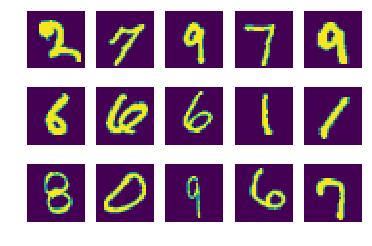

In [48]:
# Exhibits the images in the dataset
print("Labels:")

plt.figure()
for i in range(0,3):
    print(end="\n\t")
    for j in range(0,5):
        plt.subplot(3,5,j + 5*i +1)
        
        # Selects a random example from the dataset
        idx = np.random.randint(0, 60000)
        
        # Classify the example sampled
        y_hat = brain.predict(X_train[:,idx:idx+1])
        print(y_hat, end="\t")
        
        plt.imshow(X_train[:,idx].reshape(28,28))
        plt.axis('off')


print("\n\nImages:")
plt.show()

We can also evaluate the quality of the model by classifying the Testing Dataset and evaluating the overall accuracy over all examples:

In [53]:
# Prediction for all the data in the Testing Set
y_hat = brain.predict(X_test)

# Calculating the overall accuracy
overallAcc = brain.accuracy(y_test_ohe, y_hat)

print("## RESULTS ##")
print("Overall Accuracy: {0:.3f}".format(overallAcc))

## RESULTS ##
Overall Accuracy: 51.690


----